In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [ ]:
pth_data = os.path.join('..', 'data', 'modeling', 'interpret')
pth_out = os.path.join('..', 'figures', 'modeling')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_data, 'training.h5ad'))
adata

AnnData object with n_obs × n_vars = 1575028 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score'

In [4]:
# feature importance (ranks)
rank = (pd.concat((
        pd.DataFrame(
            adata.layers['IG_z'].toarray(),
            index = adata.obs_names,
            columns = adata.var_names).abs(),
        adata.obs.category), axis = 1)
    .groupby('category').mean()
    .rank(ascending = False, method = 'dense', axis = 1)
    .astype(int))

/tmp/ipykernel_466455/1924574660.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('category').mean()


In [5]:
# top features
df = pd.DataFrame(index = np.arange(1, 101),
                  columns = rank.columns)
for ix in df.index:
    df.loc[ix] = 100 * (rank <= ix).mean(axis = 0)
auc = df.mean().sort_values(ascending = False)
auc.head()

Rps20     82.643678
Pfn1      82.448276
Rpl37a    80.218391
Myl6      68.011494
Mdk        62.54023
dtype: object

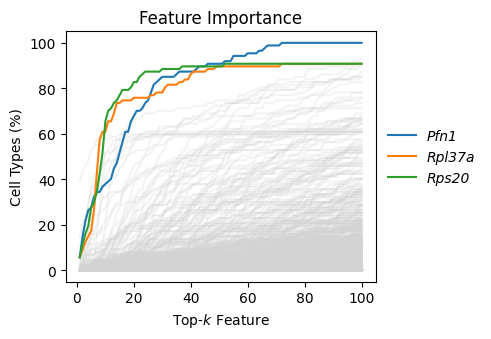

In [6]:
# plot features
fig, ax = plt.subplots(1, 1, figsize = (4, 3.25))
highlight = auc.head(3).sort_index().index
ax.plot(df, c = 'lightgray', alpha = .25)
df.loc[:, highlight].plot(ax = ax)
ax.legend(bbox_to_anchor = (1., .66),
          prop = {'style' : 'italic'},
          frameon = False)
ax.set_xlabel(r'Top-$k$ Feature')
ax.set_ylabel('Cell Types (%)')
ax.set_title('Feature Importance')
fn = os.path.join(pth_out, 'attributions.pdf')
plt.savefig(fn, bbox_inches = 'tight')